Text(0.5, 1.0, 'Image Right')

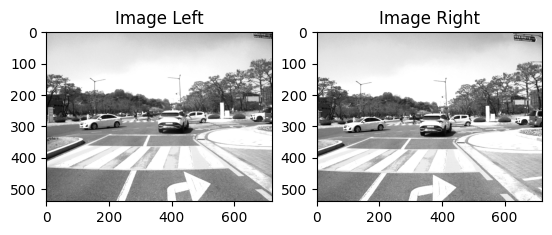

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from ipywidgets import interact, interactive, fixed
import glob

# Load the left and right images
left_image_path = 'test/left/000000.png'
right_image_path = 'test/right/000000.png'
left_image = cv2.imread(left_image_path, cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread(right_image_path, cv2.IMREAD_GRAYSCALE)

# Camera intrinsic parameters (K) and distortion coefficients (D)
K1 = np.array([[646.955997072896, 0, 374.835206750483],
               [0, 647.313486650587, 274.110353312482],
               [0, 0, 1]])
D1 = np.array([-0.233159251613014, 0.142542553330781, 0, 0, 0])

K2 = np.array([[647.665206888116, 0, 367.691476534482],
               [0, 647.665543907575, 285.201609563427],
               [0, 0, 1]])
D2 = np.array([-0.231756400305989, 0.129011020676044, 0, 0, 0])

# Rotation matrix (R) and translation vector (T)
R = np.array([[0.999995421151889, -0.00180011943011057, -0.00243253885758453],
              [0.00180115338716526, 0.999998288487383, 0.000422928813994127],
              [0.00243177337188796, -0.000427308253070042, 0.999996951938317]])
T = np.array([-497.793948992697, -2.18455982352058, 3.78473995227301])

# Image dimensions (assuming both images have the same size)
image_size = left_image.shape[::-1]

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(left_image, 'gray')
ax1.set_title('Image Left')
ax2.imshow(right_image, 'gray')
ax2.set_title('Image Right')

Text(0.5, 1.0, 'Undistorted Right')

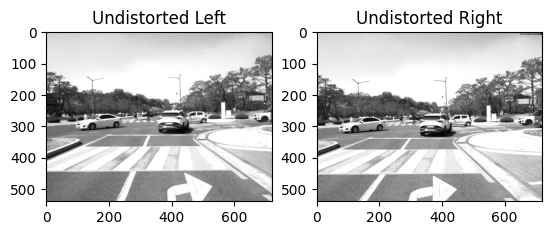

In [27]:
# Undistort the images
left_undistorted = cv2.undistort(left_image, K1, D1)
right_undistorted = cv2.undistort(right_image, K2, D2)

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(left_undistorted, 'gray')
ax1.set_title('Undistorted Left')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(right_undistorted, 'gray')
ax2.set_title('Undistorted Right')

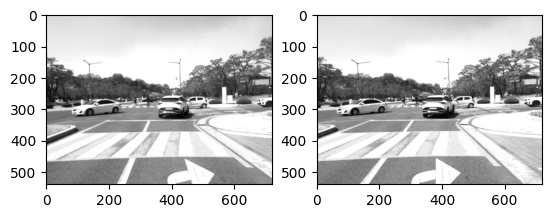

In [28]:
# Stereo rectification
R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(K1, D1, K2, D2, image_size, R, T)

# Compute the rectification maps
left_map1, left_map2 = cv2.initUndistortRectifyMap(K1, D1, R1, P1, image_size, cv2.CV_16SC2)
right_map1, right_map2 = cv2.initUndistortRectifyMap(K2, D2, R2, P2, image_size, cv2.CV_16SC2)

# Rectify the images
left_rectified = cv2.remap(left_undistorted, left_map1, left_map2, cv2.INTER_LINEAR)
right_rectified = cv2.remap(right_undistorted, right_map1, right_map2, cv2.INTER_LINEAR)

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(left_rectified, 'gray')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(right_rectified, 'gray')

In [56]:
# Compute disparity map - find the best values for given stereo pair
def compute_disparity(left_rectified, right_rectified, num_disparities=64, block_size=11, window_size=11, show_disparity=True):

    sgbm = cv2.StereoSGBM_create(
        minDisparity=0, 
        numDisparities=num_disparities, 
        blockSize=block_size, 
        P1=8 * 3 * window_size ** 2,
        P2=32 * 3 * window_size ** 2, mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
        )

    disparity = sgbm.compute(left_rectified, right_rectified).astype(np.float32) / 16.0
    if (show_disparity==True):
        plt.figure()
        plt.imshow(disparity, "cividis")
        plt.show()
    return disparity

num_disparity = (0,512,16)
block_size = (1,19,2)
window_size = (1,13,2)
disparity = interactive(compute_disparity, 
                        left_rectified=fixed(left_rectified), 
                        right_rectified=fixed(right_rectified), 
                        num_disparities=num_disparity, 
                        block_size=block_size, 
                        window_size=window_size)
display(disparity)


interactive(children=(IntSlider(value=64, description='num_disparities', max=512, step=16), IntSlider(value=11…

{'num_disparities': IntSlider(value=64, description='num_disparities', max=512, step=16), 'block_size': IntSlider(value=11, description='block_size', max=19, min=1, step=2), 'window_size': IntSlider(value=11, description='window_size', max=13, min=1, step=2), 'show_disparity': Checkbox(value=True, description='show_disparity')}


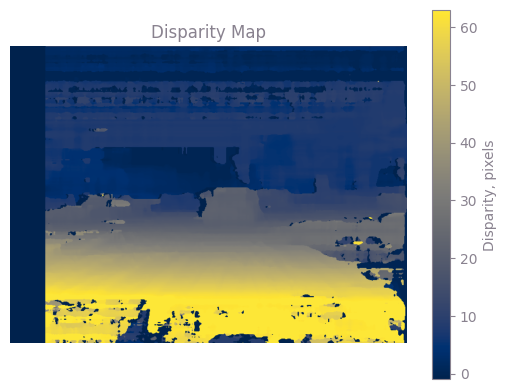

In [57]:
settings = {w.description: w for w in disparity.children if hasattr(w, 'description')}
print(settings)
disparity_map = compute_disparity(left_rectified, right_rectified, settings['num_disparities'].value, settings['block_size'].value, settings['window_size'].value, False)

text_color = "#89828F"
plt.rcParams.update({
    "text.color": text_color,        # General text (titles, labels, etc.)
    "axes.labelcolor": text_color,   # X and Y axis labels
    "xtick.color": text_color,       # X-axis tick labels
    "ytick.color": text_color,       # Y-axis tick labels
    "axes.edgecolor": text_color,    # Axis border color
})

fig, ax = plt.subplots()
im = plt.imshow(disparity_map, cmap=plt.colormaps['cividis'])
# Create a colorbar with depth values in meters
cbar = fig.colorbar(im, ax=ax, label='Disparity, pixels')

# Add title and show the plot
ax.set_title('Disparity Map')
plt.axis('off')

plt.savefig("disparity.png", bbox_inches='tight', transparent=True)


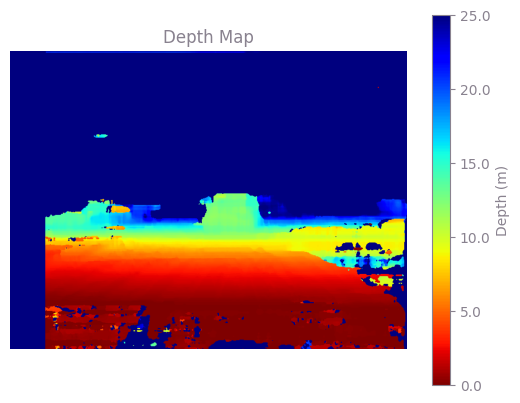

In [58]:
#Calculate depth map
def calc_depth_map(disparity, focal_length, baseline):
    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disparity[disparity == 0] = 1e-3
    disparity[disparity == -1] = 1e-3
    # Calculate the depths 
    depth_map = np.single(focal_length * baseline) / np.single(disparity)
    return depth_map

focal_length = K1[0, 0]  # Focal length in pixels
baseline = np.linalg.norm(T)  # Baseline in mm
depth_map = calc_depth_map(disparity_map, focal_length, baseline)

# Clip depth map to a reasonable range (e.g., ignore values beyond a certain depth)
max_depth = 25000  # Set a maximum depth threshold (e.g., 10 meters = 10000 mm)
depth_map_clipped = np.clip(depth_map, 0, max_depth)

# Normalize the depth map for visualization
depth_map_normalized = cv2.normalize(depth_map_clipped, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

fig, ax = plt.subplots()
im = plt.imshow(depth_map_normalized, cmap=plt.colormaps['jet_r'])
# Create a colorbar with depth values in meters
cbar = fig.colorbar(im, ax=ax, label='Depth (m)')

# Map the normalized pixel values (0-255) back to depth values in meters
cbar_ticks = np.linspace(0, 255, num=6)  # 6 ticks for the colorbar
depth_ticks = np.linspace(0, max_depth / 1000, num=6)  # Convert depth to meters

# Set the colorbar ticks and labels
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([f'{depth:.1f}' for depth in depth_ticks])

# Add title and show the plot
ax.set_title('Depth Map')
plt.axis('off')

plt.savefig("depth.png", bbox_inches='tight', transparent=True)